# Info

This notebook contains the code for:<br>
a) phasing the sequence-capture samples<br>
b) calculating various haplotype homozygosity stats (e.g. IHS) with the R package REHH

# Setup

Python

In [1]:
%run '~/jupyter/py3_functions.py'
%run '/n/home11/twooldridge/scripts/polionotus_project/polionotus_setup.py'
setupWorkspace('/n/hoekstra_lab_tier1/Users/brock/polionotus/haplotypes')


## R
from rpy2 import rinterface
#from jupyter_helpers import rpy2_autocompletion
%load_ext rpy2.ipython

R libraries & setup

In [8]:
%%R
library(tidyverse)
library(magrittr)
library(rehh)
source('~/scripts/R/R_3.5_functions.R')
source('~/scripts/polionotus_project/R_polionotus_setup.R')
setupWorkspace('/n/hoekstra_lab_tier1/Users/brock/polionotus/haplotypes')
pops = ID_POP_MAP %>% pull(POP) %>% unique %>% .[!grepl("UNK|NUB",.)]

# fastPHASE

## Input data

Create input vcf. This is involves taking the vcf, and RETAINING:
- All individuals
- All sequenced loci (no X chromosome though)
- Biallelc variants (SNP or INDEL)
- MAF > 0.01
- No more than 50% missing individuals at a given site

In [2]:
for chrom in Ppol_sizes.keys():
    if chrom == 'chrX': continue
    cmd = ('''module load bcftools vcftools\n'''
            '''bcftools view -r {chrom} -m2 -M2 /n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/popgen_vcfs/vars/ALL.vcf.gz | '''
            '''vcftools --vcf - --max-missing 0.5 --maf 0.01 --stdout --recode --recode-INFO-all | sed 's|\\t.:|\\t./.:|g'  > '''
            '''input/all.vars.{chrom}.vcf\n''').format(pop=pop,chrom=chrom)
    slurm = make_slurm(run=False,id = '%s.select' % chrom,cmd_string=cmd,mem='1000',time='00:20:00')

Convert vcf to fastPhase format using very helpful script from https://github.com/lstevison/vcf-conversion-tools

In [18]:
numsamples = subprocess.run('module load bcftools;bcftools query -l input/all.vcf | wc -l',shell=True,stdout=subprocess.PIPE,stderr=subprocess.PIPE)
numsamples = numsamples.stdout.decode('utf-8').strip()
for chrom in Ppol_sizes.keys():
    if chrom == 'chrX': continue
    cmd=('''~/Software/vcf-conversion-tools/vcf2fastPHASE.pl input/all.vars.{chrom}.vcf input/all.vars.{chrom}.inp input/all.vars.{chrom}.positions {numsamples} ''').format(numsamples=numsamples,chrom=chrom)
    #!$cmd

Reading in VCF file...done.
Now printing output...done.
Reading in VCF file...done.
Now printing output...done.
Reading in VCF file...done.
Now printing output...done.
Reading in VCF file...done.
Now printing output...done.
Reading in VCF file...done.
Now printing output...done.
Reading in VCF file...done.
Now printing output...done.
Reading in VCF file...done.
Now printing output...done.
Reading in VCF file...done.
Now printing output...done.
Reading in VCF file...done.
Now printing output...done.
Reading in VCF file...done.
Now printing output...done.
Reading in VCF file...done.
Now printing output...done.
Reading in VCF file...done.
Now printing output...done.
Reading in VCF file...done.
Now printing output...done.
Reading in VCF file...done.
Now printing output...done.
Reading in VCF file...done.
Now printing output...done.
Reading in VCF file...done.
Now printing output...done.
Reading in VCF file...done.
Now printing output...done.
Reading in VCF file...done.
Now printing output.

I also need to get population order, print on single tab-delimited row

In [19]:
%%bash
module load bcftools
POPSTRING=""
while read SAMPLE;do
    POP=$(awk -v var=$SAMPLE '{OFS="\t"} ($1 == var) {print $2}' ../poplists/wgs_seq_pops_alternate.txt | cut -f2) ;
    if [[ $POP == "" ]];then echo "$SAMPLE";if [[ $SAMPLE == *"JNW"* ]];then echo "found JNW sample";POP="JNW";fi;fi;
    POPSTRING="$POPSTRING\t$POP";
done< <(bcftools query -l input/all.vars.chr1.vcf)
echo -e $POPSTRING | sed 's/^\t//' > popheader.txt

These population labels need to be replaced with integers, so I construct a sed string to do this

In [20]:
sedstring = 'sed \''
for i,POP in enumerate(list(pop_sample_map.keys()) + ['JNW']):
    i = i +1
    sedstring = sedstring + 's/\<%s\>/%s/g;' % (POP,i)
sedstring = sedstring + '\''
cmd = '%s popheader.txt > subpoplabels.inp' % sedstring
!$cmd

## Run fastPhase

Now run fastPHASE on the whole dataset

In [3]:
for chrom in Ppol_sizes.keys():
    if chrom == 'chrX': continue
    cmd=('''~/Software/fastPHASE -T20 -H50 -F -oall.vars{chrom} -usubpoplabels.inp input/all.vars.{chrom}.inp\n '''
         '''mv all.vars.{chrom}* output/ ''').format(chrom=chrom)
    slurm = make_slurm(run=False,id='fp.%s' % chrom,cmd_string=cmd,mem='120000',time='120:00:00')

## Convert output back to vcf

In [4]:
numsamples = subprocess.run('module load bcftools;bcftools query -l input/all.vcf | wc -l',shell=True,stdout=subprocess.PIPE,stderr=subprocess.PIPE)
numsamples = numsamples.stdout.decode('utf-8').strip()
for chrom in Ppol_sizes.keys():
    if chrom == 'chrX': continue
    cmd=('''~/Software/vcf-conversion-tools/fastPHASE2VCF.pl '''
         '''input/all.{chrom}.inp '''
         '''output/all.{chrom}_hapguess_switch.out '''
         '''input/all.{chrom}.vcf '''
         '''output/{chrom}.phased.vcf '''
         '''{chrom}\n'''
         '''/n/home11/twooldridge/scripts/zip_index_vcf.sh output/{chrom}.phased.vcf''').format(chrom=chrom)
    #!$cmd

Now split the phased vcf into different populations

In [5]:
for chrom in Ppol_sizes.keys():
    if chrom == 'chrX': continue
    for pop in pop_sample_map.keys():
        #cmd = ('''module load vcftools\n'''
        #       '''vcftools --gzvcf output/{chrom}.phased.vcf.gz --keep ../poplists/{pop}.poplist.txt --stdout --recode --recode-INFO-all | sed 's/0|0:\.:\.:\./.|\.:\.:\./g' > output/{pop}.{chrom}.phased.vcf\n'''
        #       '''/n/home11/twooldridge/scripts/zip_index_vcf.sh output/{pop}.{chrom}.phased.vcf''').format(chrom=chrom,pop=pop)
        cmd = ('''module load vcftools\n'''
               '''vcftools --gzvcf output/{chrom}.phased.vcf.gz --keep ../poplists/{pop}.poplist.txt --stdout --recode --recode-INFO-all > output/{pop}.{chrom}.phased.vcf\n'''
               '''/n/home11/twooldridge/scripts/misc/zip_index_vcf.sh output/{pop}.{chrom}.phased.vcf''').format(chrom=chrom,pop=pop)
        slurm = make_slurm(echo=False,id='%s.%s.subset' % (pop,chrom),cmd_string=cmd,mem='500',time='00:02:00')

# REHH

Convert to rehh format using script I wrote (hap2rehh.py)

In [6]:
!mkdir -p rehh
for chrom in Ppol_sizes.keys():
    if chrom == 'chrX': continue
    for pop,samples in pop_sample_map.items():
        cmd = ('''python3 /n/home11/twooldridge/scripts/misc/rehh/hap2rehh.py '''
               '''--vcf output/{pop}.{chrom}.phased.vcf.gz '''
               '''--ref {ref_genome} '''
               '''--out rehh/{pop}.{chrom}.refpol ''').format(ref_genome=ref_genome,pop=pop,chrom=chrom)
        slurm = make_slurm(run=False,id='%s.%s.hap2rehh' % (pop,chrom),cmd_string=cmd,mem='1000',time='00:40:00')

Read in haplotype files for REHH to partse, using the reference genome here as the ancestor just for simplicity's sake. When I run the same thing using an outgroup (e.g. P. maniculatus nubiterrae) or an inferred ancestral sequence, I get the same result in terms of absolute IHS values, just the polarity changes (e.g. -2.2 instead of 2.2). This is because ancestral vs. derived allele might change, but the homozygosity patterns stay the same

In [11]:
%%R
pops = ID_POP_MAP %>% pull(POP) %>% unique %>% .[!grepl("UNK|NUB",.)]
#pops = c('POALB')
haplohh =
lapply(pops,
       function(pop){hhlist = lapply(Ppol_chroms %>% .[!grepl("chrX",.)] ,
                                     function(chrom){
                                             data2haplohh(hap_file = paste0('rehh/',pop,'.',chrom,'.refpol.thap'),
                                             map_file = paste0('rehh/',pop,'.',chrom,'.refpol.inp'), 
                                             allele_coding = 'map', 
                                             haplotype.in.columns = TRUE,
                                             verbose = FALSE)
                            });names(hhlist) = Ppol_chroms %>% .[!grepl("chrX",.)];return(hhlist)})
names(haplohh) = pops

Calculate IHS

In [13]:
%%R
scans =
lapply(haplohh,
       function(popdataset){lapply(popdataset, 
                            function(popbychrom){scan_hh(popbychrom,discard_integration_at_border = FALSE, maxgap = 2000, polarized=TRUE)})})

popscans =
lapply(scans, 
       function(popdataset){rbindlist(popdataset)})
names(popscans) = pops


# IHS
ihs =
lapply(popscans,function(popscan){ihh2ihs(popscan,min_maf = 0.05, p.adjust.method="none")})
names(ihs) = pops

ihs = rbindlist(lapply(names(ihs),function(popname){ihs[[popname]]$ihs %>% mutate(pop=popname)}))

Discard focal markers with Minor Allele Frequency equal to or below 0.05 .
11114 markers discarded.
3226 markers remaining.
Discard focal markers with Minor Allele Frequency equal to or below 0.05 .
7625 markers discarded.
6715 markers remaining.
Discard focal markers with Minor Allele Frequency equal to or below 0.05 .
10477 markers discarded.
3863 markers remaining.
Discard focal markers with Minor Allele Frequency equal to or below 0.05 .
10410 markers discarded.
3930 markers remaining.
Discard focal markers with Minor Allele Frequency equal to or below 0.05 .
8457 markers discarded.
5883 markers remaining.
Discard focal markers with Minor Allele Frequency equal to or below 0.05 .
9401 markers discarded.
4939 markers remaining.
Discard focal markers with Minor Allele Frequency equal to or below 0.05 .
10983 markers discarded.
3357 markers remaining.
Discard focal markers with Minor Allele Frequency equal to or below 0.05 .
10872 markers discarded.
3468 markers remaining.
Discard foc

## Albifrons

Any outliers around focal region in POALB?

In [20]:
%%R
ihs %>% 
    filter(pop == "POALB",CHR == "chr4", POSITION > 9840000, POSITION < 9850000, IHS > 1.96)

     CHR POSITION      IHS LOGPVALUE   pop
 1: chr4  9844849 1.986423  1.328028 POALB
 2: chr4  9844930 2.854648  2.365678 POALB
 3: chr4  9844954 2.638249  2.079171 POALB
 4: chr4  9845040 2.736975  2.207559 POALB
 5: chr4  9845116 2.536478  1.950884 POALB
 6: chr4  9845152 2.481483  1.883270 POALB
 7: chr4  9845301 2.414497  1.802528 POALB
 8: chr4  9845470 2.334834  1.708807 POALB
 9: chr4  9846254 2.193923  1.549121 POALB
10: chr4  9846286 2.835768  2.339935 POALB
11: chr4  9846292 2.865009  2.379867 POALB
12: chr4  9846293 2.732454  2.201595 POALB
13: chr4  9846308 3.091811  2.701279 POALB
14: chr4  9846815 3.282624  2.987814 POALB
15: chr4  9846908 3.756085  3.762979 POALB
16: chr4  9846954 3.047962  2.637519 POALB
17: chr4  9846977 2.419287  1.808242 POALB
18: chr4  9847023 2.563728  1.984830 POALB


Distribution of IHS values from full dataset, compared to pPC1-associated SNPs

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



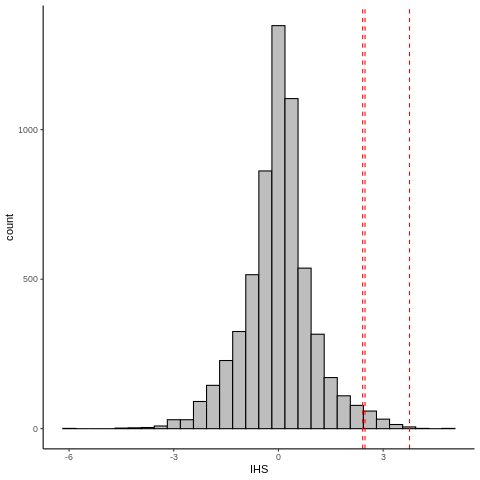

In [31]:
%%R
s = ihs %>% filter(pop == "POALB")
#s %<>% filter(POSITION %in% c(9845152,9845301,9846908))
ggplot() +
    geom_histogram(data = s, aes(x = IHS), color = 'black', fill = 'gray') +
    geom_vline(data = s %>% filter(POSITION %in% c(9845152,9845301,9846908)), aes(xintercept = IHS), lty = 2, color = 'red' ) +
    theme_classic()

Haplotype homozygosity at top associated SNP

In [15]:
%%R
head(popscans[['POALB']] %>% filter(POSITION == 9845301))

    CHR POSITION    FREQ_A    FREQ_D NHAPLO_A NHAPLO_D    IHH_A    IHH_D
1: chr4  9845301 0.8630952 0.1369048      290       46 4175.339 1163.428
        IES     INES
1: 2945.445 4091.113


EHH from focal  SNP. Light allele is coded as 'A' (Ancestral)

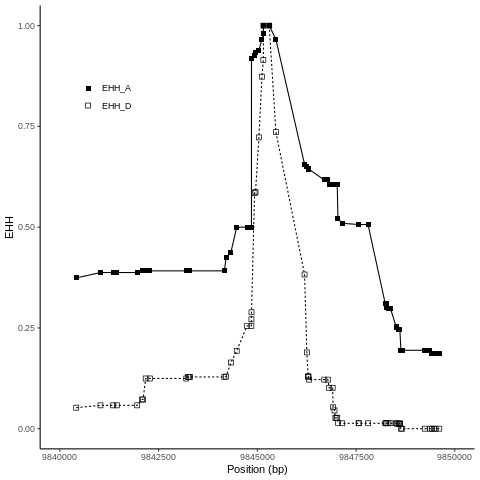

In [17]:
%%R
focal_ehh = calc_ehh(haplohh[["POALB"]][["chr4"]], mrk='chr4_9845301',limehh=0.01)
ehhplottable = focal_ehh$ehh %>% pivot_longer(-POSITION, names_to = "EHH", values_to = "VALUE")

ggplot(ehhplottable) +
    geom_point(aes(x=POSITION,y=VALUE,shape = EHH),size=2) +
    geom_line(aes(x=POSITION,y=VALUE, linetype= EHH)) +
    scale_shape_manual(values=c(15,0)) +
    ylab("EHH") +
    xlab("Position (bp)") +
    theme_classic() +
    #ggtitle("Extended haplotype homozygosity (EHH) around 9,845,301 bp") +
    theme(legend.title=element_blank(),legend.position = c(0.15,0.8), plot.title = element_text(size=10,hjust = 0.5)) +
    xlim(c(9840000,9850000)) +
    guides(linetype="none")

Bifurcation diagrams

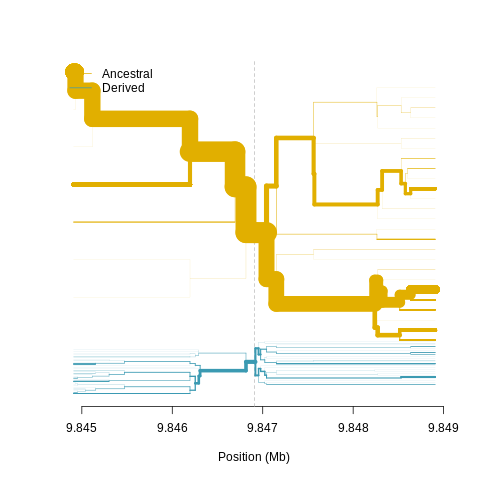

In [18]:
%%R
f <- calc_furcation(haplohh[["POALB"]][4][[1]], mrk = "chr4_9846908")
options(repr.plot.height=5,repr.plot.width=5)
buffer = 2000
plot(f,
     # increase line width
     lwd = 0.1,
     # set habplotype identifiers as labels
     hap.names = hap.names(haplohh[["POALB"]][4][[1]]),
     # find a place for the legend ...
     #legend.xy.coords = c(1, 0.2),
     xlim = c(9846908-buffer,9846908+buffer),
     col = wes_palette("Zissou1")[c(4,1)],
     main = "",
     #xlab = "",
     #axes = FALSE
)

Albifrons IHS outliers (Z-score > 1.96) around focal region:

In [19]:
%%R
ihs %>% 
    filter(pop == "POALB",CHR == "chr4", POSITION > 9840000, POSITION < 9850000, IHS > 1.96)

     CHR POSITION      IHS LOGPVALUE   pop
 1: chr4  9844849 1.986423  1.328028 POALB
 2: chr4  9844930 2.854648  2.365678 POALB
 3: chr4  9844954 2.638249  2.079171 POALB
 4: chr4  9845040 2.736975  2.207559 POALB
 5: chr4  9845116 2.536478  1.950884 POALB
 6: chr4  9845152 2.481483  1.883270 POALB
 7: chr4  9845301 2.414497  1.802528 POALB
 8: chr4  9845470 2.334834  1.708807 POALB
 9: chr4  9846254 2.193923  1.549121 POALB
10: chr4  9846286 2.835768  2.339935 POALB
11: chr4  9846292 2.865009  2.379867 POALB
12: chr4  9846293 2.732454  2.201595 POALB
13: chr4  9846308 3.091811  2.701279 POALB
14: chr4  9846815 3.282624  2.987814 POALB
15: chr4  9846908 3.756085  3.762979 POALB
16: chr4  9846954 3.047962  2.637519 POALB
17: chr4  9846977 2.419287  1.808242 POALB
18: chr4  9847023 2.563728  1.984830 POALB


## Figure 5 left side

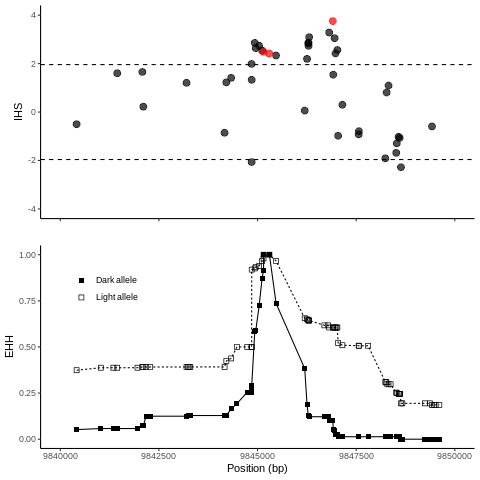

In [35]:
%%R
visbuffer = 5e2
gene_chrom = as.character(agouti$chr)
gene_start = agouti$start
gene_end = agouti$end

ihsplottable = ihs %>% filter(pop %in% c("POALB"), CHR == gene_chrom, POSITION > gene_start, POSITION < gene_end)
sigpos = c(9845152,9845301,9846908)
ihsplottable %<>% mutate(GWAS = ifelse(POSITION %in% sigpos,"Y","N"))

focal_ehh = calc_ehh(haplohh[["POALB"]][["chr4"]], mrk='chr4_9845301',limehh=0.01)
ehhplottable = focal_ehh$ehh %>% dplyr::rename("Reference"="EHH_A","Alternate"="EHH_D") %>% pivot_longer(-POSITION, names_to = "EHH", values_to = "VALUE")

ptsize = 3
ihsplot = 
    ggplot() +
    geom_point(data = ihsplottable %>% filter(GWAS == "N"), aes(x=POSITION, y = IHS), alpha = 0.7, color = "black", size = ptsize) +
    geom_point(data = ihsplottable %>% filter(GWAS == "Y"), aes(x=POSITION, y = IHS), alpha = 0.7, color = "red", size = ptsize) +
    geom_hline(aes(yintercept=1.96),lty=2) +
    geom_hline(aes(yintercept=-1.96),lty=2) +
    #geom_rect(data = outliers %>% filter(pop %in% plotpops) %>% dplyr::select(CHR,START,END,pop) %>% distinct,aes(xmin=START+1 - visbuffer,xmax=END+ visbuffer,ymin=-Inf,ymax=Inf, fill = pop),alpha=0.2,size=10) +
    theme_classic() +
    #ggtitle("Integrated haplotype score (IHS) for POALB") +
    theme(plot.title = element_text(size=10,hjust = 0.5), axis.text.x = element_blank()) +
    xlab("") + 
    ylim(c(-4,4)) +
    xlim(c(9840000,9850000))

ehhplot = 
    ggplot(ehhplottable) +
    geom_point(aes(x=POSITION,y=VALUE,shape = EHH),size=2) +
    geom_line(aes(x=POSITION,y=VALUE, linetype= EHH)) +
    scale_shape_manual(values=c(15,0),labels = c("Dark allele","Light allele")) +
    ylab("EHH") +
    xlab("Position (bp)") +
    theme_classic() +
    #ggtitle("Extended haplotype homozygosity (EHH) around 9,845,301 bp") +
    theme(legend.title=element_blank(),legend.position = c(0.15,0.8), plot.title = element_text(size=10,hjust = 0.5)) +
    xlim(c(9840000,9850000)) +
    guides(linetype="none")

plot_grid(ihsplot,ehhplot,ncol=1, align = "v", axis = "lr", rel_heights = c(1,1))
#ggsave('~/temp/polionotus/haplotypeplot.svg')